# Loss Functions

When fitting data to labels we need to measure the degree of goodness of fit. This sounds obvious but isn't quite so straightforward. In fact, there are entire fields of statistics that focus solely on that (e.g. robust statistics). In this notebook we'll discuss a number of ways how we can measure whether our model is doing well. As a side-benefit, we'll get to know the loss function layers in ``gluon``. We begin with our default import ritual.

In [1]:
import mxnet as mx
import mxnet.gluon as gluon
from mxnet import nd, autograd
import matplotlib.pyplot as plt
import numpy as np
import mxnet.autograd as ag
mx.random.seed(1)

## Regression - L1 loss

As we discussed in the introduction, regression describes the cases where we want to estimate some real valued number $f(x) \in \mathbb{R}$ to match an observation $y$. A natural idea of measuring the distance would be to compute $|y - f(x)|$. This makes sense, e.g. if we need to estimate how much it might cost to manufacture a product: if we estimate too low, we will incur a loss due to underestimation. If we overprice it, we will sell fewer products (here we're making the unrealistic assumption that both are equally bad). In math, the loss function is

$$l(y,f) = |y-f|$$

Let's compute it with ``gluon`` and also its gradient. 

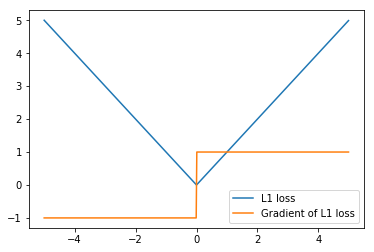

In [2]:
loss = gluon.loss.L1Loss()

# getting data ready
output = nd.arange(-5,5,0.01)
output.attach_grad() # we need the gradient
thelabel = nd.zeros(shape=(output.size)) 
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L1 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L1 loss')
plt.legend()
plt.show()

Before we move on to other losses, let's quickly consider what happens if we want to minimize the L1 loss. Consider the toy example where we have a number of labels $y_i$ and we want to fit *all* of them to a single scalar, say $f$. In this case we need to solve the minimization problem:

$$\mathop{mathrm{minimize}}_f \sum_i |y_i - f|$$

As we saw above, the gradient is either -1 or 1. Hence, for the gradients to the left and to the right of $f$ to cancel out we need *the same number of $y_i$* on either side. This is the definition of the *median*. Hence, minimizing the L1 loss means that we are computing the median (at least for constant predictions). In general, the L1 loss is very robust against outliers, since the gradients can never get too large. 

## Regression - L2 loss

Taking the squared distance between observation and estimate tends to be the default choice in many problems. Often for convenience we multiply this loss by a factor of $\frac{1}{2}$ to ensure that the derivatives look pretty. Here's the loss:

$$l(y,f) = \frac{1}{2} (y-f)^2$$

For vectorial $f$ and $y$ this is the squared Euclidean distance between points. The L2 loss has a few other nice properties. By a similar argument as before we can see that $\sum_{i=1}^m \frac{1}{2} (y_i - f)^2$ is minimized by choosing $f = \frac{1}{m} \sum_{i=1}^m y_i$, i.e. by choosing the mean. Let's see what it looks like in practice.

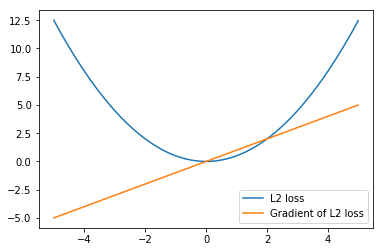

In [3]:
loss = gluon.loss.L2Loss()

with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='L2 loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of L2 loss')
plt.legend()
plt.show()

## Classification - Logistic Regression

Next consider the case where we have two labels, say ``cat`` and ``dog``. Since statisticians (and computers) don't like strings, we simplify this to $y \in \{\pm 1\}$. One way of mapping real numbers in $\mathbb{R}$ into class probabilities is to use a sigmoid function.

$$p(y|f) = \frac{1}{1 + \exp(-y f)} \text{ and hence } -\log p(y|f) = \log(1 + \exp(-y f))$$

Note that to keep the term numerically stable we can rewrite it as $-yf + \log(1 + \exp(yf))$ whenever $yf < 0$. The reason for doing this is to avoid exponentiating a large positive number which would trigger a numerical overflow.  Combining both expressions we get the following expression: $\log(1 + \exp(-|yf|)) - \delta(yf < 0) \cdot yf$. This is what we implement below. Note the small spike at $yf = 0$ due to the absolute value (this doesn't matter since it's only for a set of measure zero, i.e. we won't really encounter it).

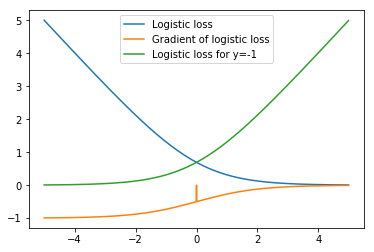

In [7]:
def logistic(f,y):
    prod = f * y
    return nd.log(1 + nd.exp(-nd.abs(prod))) - (prod < 0) * prod

loss = logistic

# getting data ready
thelabel = nd.ones(shape=(output.size)) 
with ag.record():    # start recording
    theloss = loss(output, thelabel)
theloss.backward()   # and compute the gradient

plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss')
plt.plot(output.asnumpy(), output.grad.asnumpy(), label='Gradient of logistic loss')
# now compute the loss for y=-1
theloss = loss(output, -thelabel)
plt.plot(output.asnumpy(), theloss.asnumpy(), label='Logistic loss for y=-1')
plt.legend()
plt.show()

As we can see, the loss function asymptotes the negative identity function for very negative values of $yf$. For very large positive values of $yf$, the loss converges to 0. This is desirable, since large values of $yf$ mean that the classification is correct. 

## Classification - Multiclass Softmax

One way of dealing with multiple classes is to turn it into $n$ binary classification problems. That is, we simply test: 'is it class 1', 'is it class 2', ... 'is it class n'. In theory this sounds like a splendid idea. After all, this should be just as easy as determining which class it is. Unfortunately, that's not quite the case. Imagine the situation where none of the $n$ classifiers wants to take responsibility. Or imagine the case where more than one claims that it's his turn. Obviously there has to be a better way. Indeed, there is.

If we have a vector $f \in \mathbb{R}^n$ of scores, where the coordinate, say $f_i$ is large whenever we think that the correct class is $i$, then we can map $f$ into a probability vector via

$$p(y=i|f) \propto \exp(f_i) \text{ and hence } p(y=i|f) = \frac{\exp(f_i)}{\sum_j \exp(f_j)}$$

Here the normalization by $\sum_j \exp(f_j)$ is needed such that all the terms sum up to 1. Consequently the negative log-likelihood $-\log p(y|f)$, i.e. the quantity that we would want to minimize in this case is given by 

$$-\log p(y=i|f) = \log \left[\sum_{j} \exp(f_j)\right] - f_i$$

In ``gluon`` the relevant function is [mxnet.gluon.loss.SoftmaxCrossEntropyLoss](http://mxnet.io/api/python/gluon.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss). Let's check that this is correct.

In [18]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

f = nd.random_normal(shape=(1,10))
y = nd.array([4]) #class 4 is true

print('Softmax loss is {}.'.format(loss(f,y).asscalar()))

# now compute this by hand

p = nd.exp(f)
p = p / nd.sum(p)
print('Class 4 has negative log-likelihood {}.'.format(-nd.log(p[0,4]).asscalar()))

Softmax loss is 3.007002353668213.
Class 4 has negative log-likelihood 3.007002592086792.


In [ ]:
# generate fake data that is linearly separable with a margin epsilon given the data
def getfake(samples, dimensions, epsilon):
    wfake = nd.random_normal(shape=(dimensions))   # fake weight vector for separation
    bfake = nd.random_normal(shape=(1))            # fake bias
    wfake = wfake / nd.norm(wfake)                 # rescale to unit length

    # making some linearly separable data, simply by chosing the labels accordingly
    X = nd.zeros(shape=(samples, dimensions))
    Y = nd.zeros(shape=(samples))

    i = 0
    while (i < samples):
        tmp = nd.random_normal(shape=(1,dimensions))
        margin = nd.dot(tmp, wfake) + bfake
        if (nd.norm(tmp).asscalar() < 3) & (abs(margin.asscalar()) > epsilon):
            X[i,:] = tmp
            Y[i] = 2*(margin > 0) - 1
            i += 1
    return X, Y

# plot the data with colors chosen according to the labels
def plotdata(X,Y):
    for (x,y) in zip(X,Y):
        if (y.asscalar() == 1):
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='r')
        else:
            plt.scatter(x[0].asscalar(), x[1].asscalar(), color='b')

# plot contour plots on a [-3,3] x [-3,3] grid 
def plotscore(w,d):
    xgrid = np.arange(-3, 3, 0.02)
    ygrid = np.arange(-3, 3, 0.02)
    xx, yy = np.meshgrid(xgrid, ygrid)
    zz = nd.zeros(shape=(xgrid.size, ygrid.size, 2))
    zz[:,:,0] = nd.array(xx)
    zz[:,:,1] = nd.array(yy)
    vv = nd.dot(zz,w) + b
    CS = plt.contour(xgrid,ygrid,vv.asnumpy())
    plt.clabel(CS, inline=1, fontsize=10)
            
X, Y = getfake(50, 2, 0.3)
plotdata(X,Y)
plt.show()

Now we are going to use the simplest possible algorithm to learn parameters. It's inspired by the [Hebbian Learning Rule](https://en.wikipedia.org/wiki/Hebbian_theory) which suggests that positive events should be reinforced and negative ones diminished. The analysis of the algorithm is due to Rosenblatt and we will give a detailed proof of it after illustrating how it works. In a nutshell, after initializing parameters $w = 0$ and $b = 0$ it updates them by $y x$ and $y$ respectively to ensure that they are properly aligned with the data. Let's see how well it works:

In [ ]:
def perceptron(w,b,x,y):
    if (y * (nd.dot(w,x) + b)).asscalar() <= 0:
        w += y * x
        b += y
        return 1
    else:
        return 0

w = nd.zeros(shape=(2))
b = nd.zeros(shape=(1))
for (x,y) in zip(X,Y):
    res = perceptron(w,b,x,y)
    if (res == 1):
        print('Encountered an error and updated parameters')
        print('data   {}, label {}'.format(x.asnumpy(),y.asscalar()))
        print('weight {}, bias  {}'.format(w.asnumpy(),b.asscalar()))
        plotscore(w,b)
        plotdata(X,Y)
        plt.scatter(x[0].asscalar(), x[1].asscalar(), color='g')
        plt.show()

As we can see, the model has learned something - all the red dots are positive and all the blue dots correspond to a negative value. Moreover, we saw that the values for $w^\top x + b$ became more extreme as values over the grid. Did we just get lucky in terms of classification or is there any math behind it? Obviously there is, and there's actually a nice theorem to go with this. It's the perceptron convergence theorem.

## The Perceptron Convergence Theorem

**Theorem** Given data $x_i$ with $\|x_i\| \leq R$ and labels $y_i \in \{\pm 1\}$ for which there exists some pair of parameters $(w^*, b^*)$ such that $y_i((w^*)^\top x_i + b) \geq \epsilon$ for all data, and for which $\|w^*\| \leq 1$ and $b^2 \leq 1$, then the perceptron algorithm converges after at most $2 (R^2 + 1)/\epsilon^2$ iterations.

The cool thing is that this theorem is *independent of the dimensionality of the data*. Moreover, it is *independent of the number of observations*. Lastly, looking at the algorithm itself, we see that we only need to store the mixtakes that the algorithm made - for the data that was classified correctly no update on $(w,b)$ happened. 
As a first step, let's check how accurate the theorem is.